# **평균 이동(Mean Shift)**

: K-평균이 중심에 소속된 데이터의 평균 거리 중심으로 이동하는 데 반해, 평균 이동은 중심을 데이터가 모여 있는 밀도가 가장 높은 곳으로 이동시킴.

* 평균 이동 군집화는 데이터의 분포도를 이용해 군집 중심점을 찾음.
* 군집 중심점은 확률 밀도 함수 이용.
*  가장 집중적으로 데이터가 모여있어 확률 밀도 함수가 피크인 점을 군집 중심점으로 선정하며 일반적으로 주어진 모델의 확률 밀도 함수를 찾기 위해서 KDE(Kernel Density Estimation)를 이용.

---
**KDE(Kernel Density Estimation)** : 커널(Kern이) 함수를 통해 어떤 변수의 확률 밀도 함수를 추정하는 대표적인 방법.

관측된 데이터 각각에 커널 함수를 적용한 값을 모두 더한 뒤 데이터 건수로 나눠 확률 밀도 함수를 추정.  대표적인 커널 함수로서 가우시안 분포 함수가 사용됨.

대역폭 오는 KDE 형태를 부드러운(또는 뾰족한) 형태로 평활화(Smoothing)하는 데 적용되며, 이 h를 어떻게 설정하느냐에 따라 확률 밀도 추정 성능을 크게 좌우할 수 있음.

* 작은 h 값은 좁고 뾰족한 KDE를 가지게 되며, 이는 변동성이 큰 방식으로 확률 밀도 함수를 추정하므로 과적합(over-fitting)하기 쉬움,
* 큰 h 값은 과도하게 평활화(smoothing)된 KDE로 인해 지나치게 단순화된 방식으로 확률 밀도 함수를 추정하며 결과적으로 과소적합(under-fitting)하기 쉬움.

일반적으로 평균 이동 군집화는 대역폭이 클수록 평활화된 KDE로 인해 적은 수의 군집 중심점을 가지며 대역폭이 적을수록 많은 수의 군집 중심점을 가짐.

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


In [2]:
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


In [3]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.816


In [4]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1','ftr2'])
clusterDF['target'] = y

# estimator_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


/tmp/ipython-input-3686142462.py:19: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='' % label)


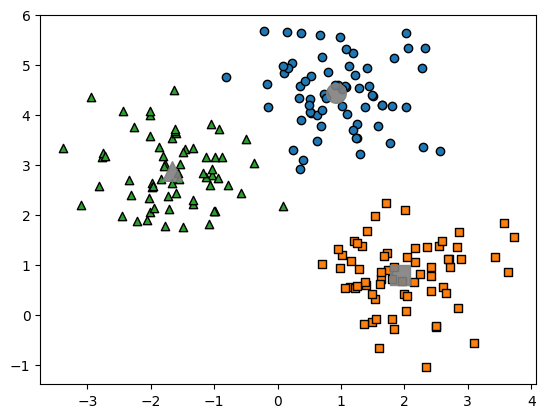

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
  label_cluster = clusterDF [clusterDF['meanshift_label']==label]
  center_x_y = centers[label]

  # 군집별로 다른 마커로 산점도 적용
  plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])

  # 군집별 중심 표현
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9,
            marker=markers[label])
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='' % label)

plt.show()

In [16]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


# **GMM(Gaussian Mixture Model)**

: GMM 군집화는 군집화를 적용하고자 하는 데이터가 여러 개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정하에 군집화를 수행하는 방식.

 모수 추정을 위해 GMM은 EM(Expectation and Maximization) 방법을 적용.

 사이킷런은 이러한 GMM의 EM 방식을 통한 모수 추정 군집화를 지원하기 위해 GaussianMixture 클래스를 지원.

 *  GaussianMixture 객체의 가장중요한초기화파라미터는 n_components. n_components는 gaussian mixture의 모델의 총 개수. K-평균의 n_clusters와 같이 군집의 개수를 정하는 데 중요한 역할을 수행.

GMM을 이용한 붓꽃 데이터 세트 군집화

In [17]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as pit
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal—width', 'petal_length', 'petal_width']

# 좀 더 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [18]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 군집화 결과를 irisDF의 'gmicluster' 칼럼명으로 저장
irisDF ['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target

# target 값에 따라 gmm_cluster 값이 어떻게 매핑됐는지 확인.
iris_result = irisDF .groupby(['target'])['gmm_cluster']. value_counts()
print(iris_result)

target  gmm_cluster
0       1              50
1       0              45
        2               5
2       2              50
Name: count, dtype: int64


이는 어떤 알고리즘에 더 뛰어나다는 의미가 아니라 붓꽃 데이터 세트가 GMM 군집화에 더 효과적이라는 의미.

 붓꽃 데이터 세트의 K-평균 군집화를 수행한 결과

In [19]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       0                 47
        2                  3
2       2                 36
        0                 14
Name: count, dtype: int64


 GMM과 K—평균의 비교

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

%matplotlib inline

def visualize_cluster_plot(cluster_result=None, dataframe=None, label_name='target', iscenter=True):
    if dataframe is None:
        print("Error: DataFrame is required.")
        return

    unique_labels = np.unique(dataframe[label_name])
    markers = ['o', 's', '^', 'x', '*', 'D', '+', 'v', '<', '>']

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name] == label]
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k',
                    marker=markers[label % len(markers)])

        if iscenter and cluster_result is not None and hasattr(cluster_result, 'cluster_centers_'):
            # Assuming cluster_result has a .cluster_centers_ attribut
            center_x_y = cluster_result.cluster_centers_[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9,
                        marker=markers[label % len(markers)])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k',
                        marker='' % label)
    plt.show()

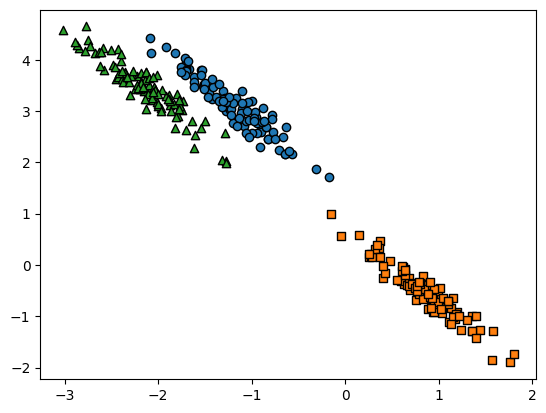

In [22]:
# make_blobs()로 300개의 데이터 세트, 3개의 군집 세트, cluster_std=0.5를 만듦.
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 세트를 생성하기 위해 변환함.
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
# feature 데이터 세트와 make_blobs( )의 y 결괏값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
# 생성된 데이터 세트를 target별로 다른 마커로 표시해 시각화함
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

KMeans의 군집화 정확성이 떨어지게 됨.

/tmp/ipython-input-601946575.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k',


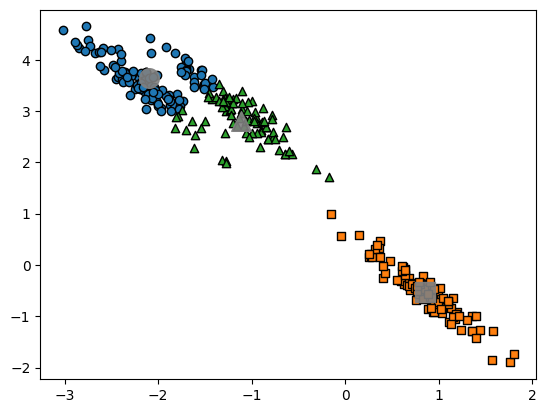

In [23]:
# 3개의 군집 기반 Kmeans를 X_aniso 데이터 세트에 적용
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label
visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

KMeans로 군집화를 수행할 경우, 주로 원형 영역 위치로 개별 군집화가 되면서 원하는 방향으로 구성되지 않음. KMeans가 평균 거리 기반으로 군집화를 수행하므로 같은 거리상 원형으로 군집을 구성하면서 위와 같이 길쭉한 방향으로 데이터가 밀접해 있을 경우에는 최적의 군집화가 어려움.

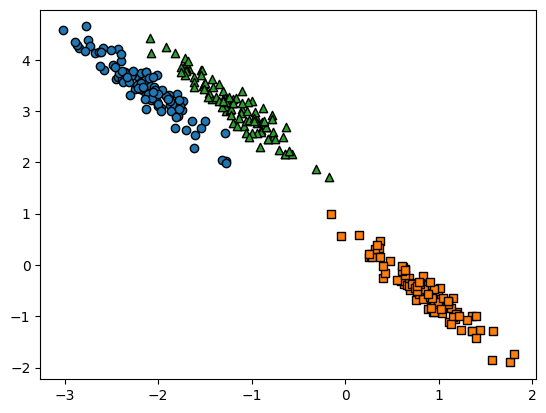

In [24]:
# 3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF ['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정.
visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscenter=False)

데이터가 분포된 방향에 따라 정확하게 군집화됐음.

In [25]:
print('### KMeans Clustering ###')
print (clusterDF.groupby('target')['kmeans_label']. value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label']. value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64


 KMeans의 경우 군집 1 번만 정확히 매핑됐지만, 나머지 군집의 경우 target 값과 어긋나는 경우가 발생. GMM의 경우는 군집이 target 값과 잘 매핑돼 있음.

  GMM의 경우는 KMeans보다 유연하게 다양한 데이터 세트에 잘 적용될 수 있다는 장점이 있음. 하지만 군집화를 위한 수행 시간이 오래 걸린다는 단점이 있음.